# exo domicile 5 - hackaton santé

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline



on exploite les sources de données suivantes:
- https://www.data.gouv.fr/fr/datasets/depenses-d-assurance-maladie-hors-prestations-hospitalieres-par-caisse-primaire-departement/ (fichier R de open damir)
- fichier complémentaire sur https://github.com/SGMAP-AGD/DAMIR:
    - fichier rpps (effectifs médecin 2013-2014 par spécialité)
    - fichier pop_par_dep_par_an_regroupe.csv (donnée insee sur la populuation)

In [2]:
data_path = "data/R_2014_sans_lib/"
liste = ['0'+str(i) if i <10 else str(i) for i in range(1,13)  ]
fichiers = [ "R2014"+x+"_sanslib.CSV" for x in liste]
fichierR_df = pd.concat([ pd.read_csv(data_path+file, sep=';', 
                          decimal=',',thousands='.',usecols=[0,17],dtype={'dep_mon':float}) for file in fichiers])


les fichiers sont découpés par mois. 
on récuppére uniquement les colonnes 0 et 17 pour les 12 mois de 2014 dans un seul dataframe.
Enfin on s'intéresse au nombre de dépassement et non au montant des dépassements. 

In [3]:
fichierR_df['count_dep']= list(map(lambda x: 1 if x > 0 else 0, fichierR_df['dep_mon']))
len(fichierR_df.index)


41580479

## Exploitation des données sur le nombre de medecin par spécialité par département

récuppération données sur les effectifs des medecins par specialités en 2014 apr département: 


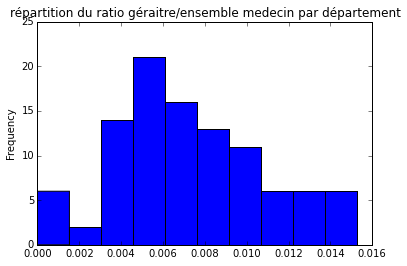

In [4]:
df_med = pd.read_csv("data/rpps_tab3.csv")
df_med= df_med[df_med['annee'] == 2014]
# récupération du code département.
regx = re.compile(r'([0-9]\w[0-9]?) -')
df_med['dep'] = list(map(lambda x: regx.search(x).groups()[0] if regx.search(x) else None , list(df_med['zone_inscription'].astype(str))))
#df_med.dropna() #removing non dep
df_med= df_med.groupby(['dep','specialite']).sum().reset_index()
#print(df_med.columns)
pivot_med = df_med.pivot(index='dep', columns='specialite', values='effectifs')
pivot_med.stack()
pivot_med['r_spe_tot'] = pivot_med['Spécialistes'] / pivot_med['Ensemble des spécialités d\'exercice']
pivot_med['r_ger_tot'] = pivot_med['Gériatrie'] / pivot_med['Ensemble des spécialités d\'exercice']
#print(pivot_med.columns)
pivot_med['r_ger_tot'].plot(kind='hist')
plt.axhline(0, color='k')
plt.title('répartition du ratio géraitre/ensemble medecin par département')


on travaille le fichier R pour rattacher les CPAM à un département (jointure avec le lexique)

In [5]:
lex = pd.read_csv("data/cpam-utf8.txt",sep=";")
df4 = pd.merge (fichierR_df, lex, left_on='cpam', right_on='cpam', how='left')
df5 = df4.groupby('dpt')['count_dep'].mean().reset_index()
#print(pd.unique(df4['dpt'].values.ravel()))
#df5.head()





count_dep                             1.000000
Gériatrie                             0.738922
Gynécologie médicale                  0.654971
Pédiatrie                             0.653324
O.R.L et chirurgie cervico faciale    0.650491
Gynécologie-obstétrique               0.639684
Ophtalmologie                         0.631163
Gastro-entérologie et hépatologie     0.629985
Oncologie option médicale             0.629289
Rhumatologie                          0.624104
Name: count_dep, dtype: float64

/Users/galicher/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


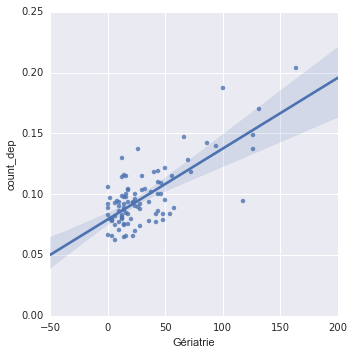

In [6]:
df6 = pd.merge(df5, pivot_med.reset_index(), left_on='dpt', right_on='dep', how='inner')
df6.head()
import seaborn as sns; sns.set(color_codes=True)
g = sns.lmplot(x="Gériatrie", y="count_dep", data=df6)
df6.corr()['count_dep'].sort_values(ascending=False).head(10)



In [7]:
test = pivot_med['Spécialistes'] + pivot_med['Généralistes'] - pivot_med['Ensemble des spécialités d\'exercice']
test.sum()

0

on constate que c'est le nombre de spécialiste en gériatrie 
qui semble avoir le plus d'impact sur le nombre de dépassement d'honoraire.

## Exploitation des données démographiques

In [32]:
dem = pd.read_csv("data/pop_par_dep_par_an_regroupe.csv",sep=";")
dem = dem[dem['annee'] > 2013]
#dem1 = dem.groupby(['dep','age_max_cat'])['value'].sum()
dem1 = dem.groupby('dep')['value'].sum().reset_index()
dem1.columns = ['dep','pop total']
print(pd.unique(dem1['dep'].values.ravel()))

['1' '10' '11' '12' '13' '14' '15' '16' '17' '18' '19' '2' '21' '22' '23'
 '24' '25' '26' '27' '28' '29' '2A' '2B' '3' '30' '31' '32' '33' '34' '35'
 '36' '37' '38' '39' '4' '40' '41' '42' '43' '44' '45' '46' '47' '48' '49'
 '5' '50' '51' '52' '53' '54' '55' '56' '57' '58' '59' '6' '60' '61' '62'
 '63' '64' '65' '66' '67' '68' '69' '7' '70' '71' '72' '73' '74' '75' '76'
 '77' '78' '79' '8' '80' '81' '82' '83' '84' '85' '86' '87' '88' '89' '9'
 '90' '91' '92' '93' '94' '95' '971' '972' '973' '974']


In [29]:
df7 = pd.merge(df6, dem1, left_on='dpt', right_on='dep', how='inner')


In [30]:
df7.head()

,dpt,count_dep,dep_x,Anatomie et cytologie pathologiques,Anesthésie-réanimation,Biologie médicale,Cardiologie et maladies vasculaires,Chirurgie générale,Chirurgie infantile,Chirurgie maxillo-faciale et stomatologie,...,Radio-thérapie,Recherche médicale,Rhumatologie,Réanimation médicale,Santé publique et médecine sociale,Spécialistes,r_spe_tot,r_ger_tot,dep_y,pop total
0,10,0.087075,10,12,60,14,42,24,0,8,...,8,0,14,2,4,710,0.483651,0.009537,10,306490
1,11,0.074436,11,10,104,26,72,22,0,14,...,10,0,36,2,4,1032,0.476454,0.006464,11,367158
2,12,0.065038,12,6,54,8,48,26,0,12,...,6,0,18,4,4,658,0.445799,0.009485,12,275063
3,13,0.100518,13,138,1058,238,674,288,44,130,...,58,2,200,26,148,10188,0.576766,0.002491,13,1996351
4,14,0.092752,14,38,254,50,158,94,8,44,...,36,0,44,2,42,2600,0.539419,0.004564,14,690836


correlation entre la demographie d'un dep et le taux de dep hon: % 0.593354111961


/Users/galicher/anaconda/lib/python3.4/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


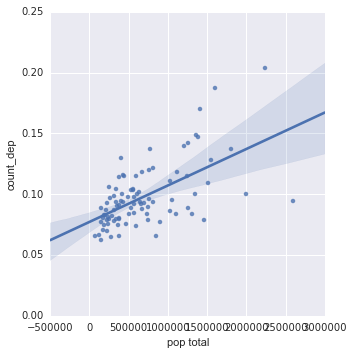

In [40]:
print( "correlation entre la demographie d'un dep et le taux de dep hon: %", df7.corr()['count_dep']['pop total'])
g = sns.lmplot(x="pop total", y="count_dep", data=df7)

la densité de population ne semble pas la variable la plus pertinente pour expliquer le taux de dépassement d'honoraire.

In [41]:
dem2 = dem.groupby(['dep','age_max_cat'])['value'].sum()

In [48]:
dem3 = dem2.transpose().reset_index().pivot(index='dep',columns='age_max_cat',values='value').reset_index()

dem3

In [50]:
dem3.columns

Index(['dep',   4.0,   9.0,  14.0,  19.0,  24.0,  29.0,  34.0,  39.0,  44.0,
        49.0,  54.0,  59.0,  64.0,  69.0,  74.0,  79.0,  84.0,  89.0,  94.0,
         inf],
      dtype='object', name='age_max_cat')

In [54]:
df8 = pd.merge(df6, dem3, left_on='dpt', right_on='dep', how='inner')
df8.columns

Index([                                              'dpt',
                                               'count_dep',
                                                   'dep_x',
                     'Anatomie et cytologie pathologiques',
                                  'Anesthésie-réanimation',
                                       'Biologie médicale',
                     'Cardiologie et maladies vasculaires',
                                      'Chirurgie générale',
                                     'Chirurgie infantile',
               'Chirurgie maxillo-faciale et stomatologie',
                 'Chirurgie orthopédique et traumatologie',
       'Chirurgie plastique reconstructrice et esthétique',
               'Chirurgie thoracique et cardio-vasculaire',
                                    'Chirurgie urologique',
                                    'Chirurgie vasculaire',
                        'Chirurgie viscérale et digestive',
                            'Dermatologi

In [65]:
liste = { x: df8.corr()[x]['Anatomie et cytologie pathologiques':'Spécialistes'].sort_values(ascending=False).head(10) for x in dem3.columns[1:]}

In [75]:
liste.get(74.0)

Médecine générale                          0.951775
Généralistes                               0.951775
Médecine physique et réadaptation          0.933611
Chirurgie urologique                       0.893646
Ensemble des spécialités d'exercice        0.883265
Chirurgie orthopédique et traumatologie    0.879256
Cardiologie et maladies vasculaires        0.878751
Gastro-entérologie et hépatologie          0.873369
Pneumologie                                0.872915
Gynécologie-obstétrique                    0.868781
Name: 74.0, dtype: float64

Est ce que la densité de certains médecins / praticiens est corrélé à la densité de population pour certaines classes d'ages (bebe/pediatre, personnes agées / infirmiers etc...) ?
Il n'y a pas de corrélation forte entre bébé et pédiatre, personnes agées / gériatres ou infirmiers ...


In [76]:
liste.get(4.0)

Médecine générale                      0.906135
Généralistes                           0.906135
Gériatrie                              0.864939
Gynécologie-obstétrique                0.839551
Médecine physique et réadaptation      0.835050
Chirurgie urologique                   0.830220
Gastro-entérologie et hépatologie      0.828617
Ensemble des spécialités d'exercice    0.824762
Pneumologie                            0.816440
Cardiologie et maladies vasculaires    0.815588
Name: 4.0, dtype: float64